<h1><center><font color=darkcyan>  Rapport final Projet Cassiopée 2018 - 2019 </font></center></h1>

<h2><center><font color=darkorange> Modèles dynamiques et machine learning (forêts aléatoires) pour la prédiction de l'inflation.</font></center></h2>

<lu>
    <li><font color=darkblue> Lionel Sopgoui</font></li>
    <li><font color=darkblue> Fritz Poka</font></li>
    <li><font color=darkblue> Sylvain Le Corff (Encadrant)</font></li>
</lu>
<hr>
<h1><center>Contenu</center></h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="introduction">Introduction</a></li>
        <li><a href="#data">Préparation des données</a></li>
        <li><a href="#ar1">Modèles autorégressifs d'ordre 1</a></li>
        <li><a href="#arp">Modèles autorégressifs d'ordre p > 1</a></li>
        <li><a href="#lasso">LASSO</a></li>
        <li><a href="#factor">Modèles factoriels</a></li>
        <li><a href="#forest">Forêts aléatoires</a></li>
        <li><a href="#compare">Comparaison des modèles</a></li>
        <li><a href="#conclusion">Conclution</a></li>
    </ol>
</div>
<br>
<hr>

<div id="introdution">
	<h2>Introduction</h2>
	<p>
		En économie, l'<b>inflation</b>est une augmentation soutenue du niveau général des prix des biens et services dans une économie sur une période donnée. 
		<br>
		L'inflation a une importance capitale en économie, les plus grandes centrales du monde en ont fait leur objectif principal : 
		<br>
		<ul>
			<li>La Banque Centrale Européenne a un seul objectif d'après Le Traité de Maastricht en 1992, <b>maintenir l'inflation en dessous de 2% mais proche de 2%.</b> Et c'est seulement lorsqu'elle a atteint cet objectif qu'elle peut s'en donner d'autres.</li>
			<li>Il en est de même pour la Réserver Fédérale Américaine : contrôler le taux d'inflation en dessous de 2%.</li>
		</ul>
		Les banques centrales définissent donc leurs différentes politiques : production de la monnaie, fixer les taux d'intérêts, acheter les dettes publiques, ... dans le but de contrôler l'inflation.
		<br>
		C'est pourquoi il est nécessaire de prédire l'inflation.
		<br>
		<br>
		De nombreux chercheurs ont donc cherché à developper des méthodes pour prédire l'inflation, qui est une grandeur correspondant au domaine des 
		<b>séries temporelles.</b>
		En se basant sur deux principaux articles 
		<i>
			<ul>
				<li>FORECASTING INFLATION IN A DATA-RICH ENVIRONMENT: THE BENEFITS OF MACHINE LEARNING METHODS</li>
				<li>Real-time inflation forecasting with high-dimensional models: The case of Brazil</li>
			</ul>
		</i>
		<br>
		Nous avons choisi 4 modèles principaux : 
		<b>Modèles autorégressifs, Modèles facoriels, LASSO, Forêts aléatoires.
		</b>
	</p>
</div>
<hr>

## <div id="data"><font color=darkred>  Préparation des données </font></div>

_On importe les bibliothèques nécessaires_

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
from pandas import Series
from matplotlib import pyplot
from scipy import linalg
from statsmodels.tsa.ar_model import AR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing, decomposition

In [41]:
import warnings
warnings.filterwarnings('ignore')

_Variables pour la validation_

In [42]:
eqm__ = []
valid__ = []

_Pour l'affichage des données par intervalle de confiance_

In [43]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    date = range(290, 325)
    plt.fill_between(date, ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(date, mean, color_mean, marker='o', label="Prediction by our model")

_Erreur quadratique moyenne_

In [44]:
def eqm(yw, ye):
    e = 0
    #print(ye.shape, yw.shape)
    n = ye.shape[0]
    for i in range(n):
        e += (yw[i] - ye[i])**2
    return np.sqrt(e/n)

_Lecture des données_

In [45]:
df = pd.read_csv("2019-04.csv")
df = df.drop("sasdate", axis=1)
CPIAUCSL = df["CPIAUCSL"].values

_La fonction inflation() calcule l'inflation en fonction de l'indice des prix à la consommation_
$inflation(t) = \frac{pci_{t}}{pci_{t-1}} - 1$

In [46]:
def inflation(pci):
    n = pci.shape[0]
    inf = np.zeros((n, 1))
    for t in range(1, n-1):
        inf[t-1] = (pci[t+1] / pci[t] - 1) * 100
    return inf

_Ajout de la colonne inflation dans l'ensemble des données_

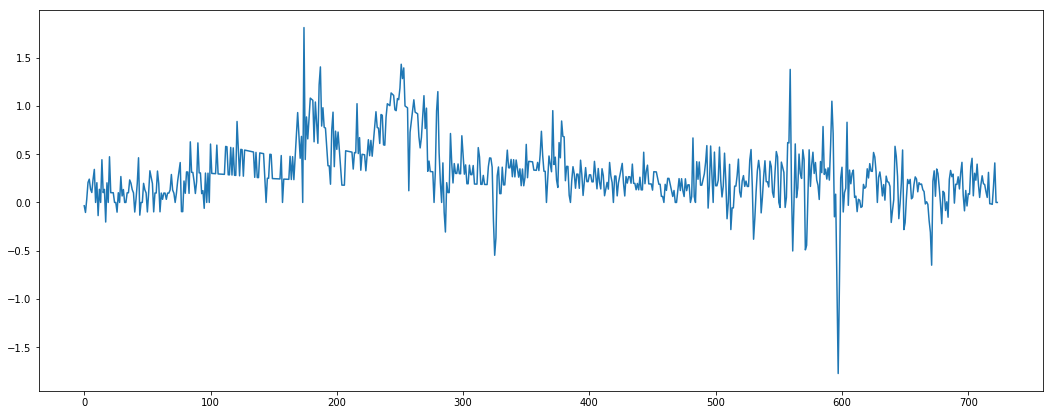

In [47]:
inf = inflation(CPIAUCSL)
plt.figure(figsize=(18,7))
plt.plot(inf)
df.insert(0, 'inflation', inf)

_On supprime les lignes contenant des valeurs nulles_

In [48]:
df = df.dropna()
df = df.reset_index(drop=True)
Y = df['inflation']
df_rf = df.copy()
df.head()

,inflation,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,-0.034471,5.000,5.0,5.000,5.000,5.0,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.00,6.0000,1.0000
1,0.215672,7968.831,6879.1,55.965,759384.431,164213.0,63.7911,70.6813,68.3934,82.2040,...,58.315,11.89,13.67,11.30,68.8,2586.2,64066.0,189752.08,744.2154,17.0505
2,0.215208,7982.053,6884.7,56.067,762440.896,163721.0,64.3212,71.2908,69.0293,82.9936,...,58.488,11.92,13.76,11.32,76.0,2611.3,62992.0,190887.95,749.7810,16.2227
3,0.286328,8011.806,6903.6,56.114,767521.889,164709.0,64.8088,71.8250,69.5483,83.7667,...,58.709,11.96,13.77,11.36,77.2,2629.0,64280.0,190911.80,755.9115,16.1885
4,0.285510,8054.634,6941.7,56.404,760844.122,165612.0,65.0202,72.2294,69.9687,84.3153,...,58.778,11.97,13.77,11.39,79.2,2652.9,62212.0,190975.14,765.6446,14.7280


_On centralise et on normalise les données_

In [49]:
df = df.drop("inflation", axis=1)
from sklearn import preprocessing
cdf = preprocessing.StandardScaler().fit_transform(df)

_On divise nos données en deux grandes périodes une période de 300 et une période de 25_

In [50]:
msk = np.concatenate(([True]*290, [False]*(35)))
X_train = cdf[msk]
Y_train = Y[msk]
date_train = [i for i in np.arange(0, 290)]
X_test = cdf[~msk]
Y_test = Y[~msk]
date_test = [i for i in np.arange(290, 325)]

Text(0, 0.5, 'Mean square error on the test data set')

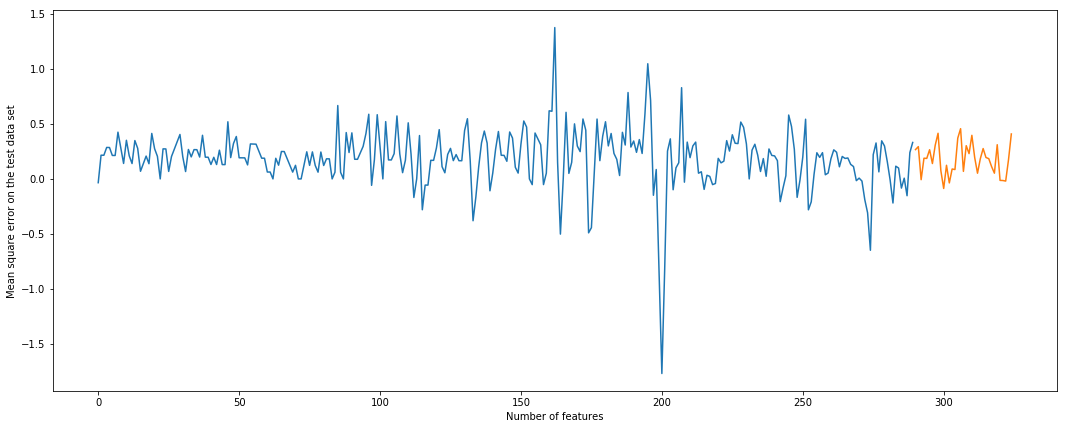

In [51]:
plt.figure(1, figsize=(18,7))
plt.plot(date_train, Y_train)
plt.plot(date_test, Y_test)
plt.xlabel('Number of features')
plt.ylabel('Mean square error on the test data set')

<hr>

## <div id="ar1"><font color=darkred>  Autorégressif d'ordre 1 </font></div>

### AR(1) model (Modèle Autoregressif d'ordre 1)
$$  \pi_{t} = a + \phi_{1} * \pi_{t-1} + \epsilon_{t}$$  $\phi_{1}$ est le paramètre à estimer.
$$ \epsilon_{t} = N(0, \sigma_{\epsilon}^2) $$

### En utilisant le maximum de vraissemblance
$$
\hat{\phi_{1}} = \frac{\sum_{t=1}^{T-1} (\pi_{t+1}-\hat{\pi})*(\pi_{t}-\hat{\pi})}{\sum_{t=1}^{T} (\pi_{t}-\hat{\pi})^2} 
$$
$$\hat{a} = \hat{\pi} * (1 - \hat{\phi_{1}})  ====>  \hat{\pi} = \frac{1}{T} \sum_{t=1}^{T} \pi_{t} $$ 

_Calcul des paramètres du modèle ($\hat{\phi_{1}}$ et $\hat{a}$)_

In [52]:
def ar_1(X):
    X = X[np.logical_not(np.isnan(X))]
    n = X.shape[0]
    X_bar = np.mean(X)
    
    num = 0
    den = 0
    for t in range(n-1):
        num += (X[t+1] - X_bar) * (X[t]-X_bar)
        den += (X[t] - X_bar) * (X[t]-X_bar)
        
    return [num/den, (X_bar * (1- num/den))]

#### Estimation de la variance de l'erreur $\epsilon_{t}$ de moyenne $\sigma^{2}$

_En utilisant la fonction de vraissemblance_

$\hat{\sigma^{2}} = \frac{1}{T} * \sum_{t=1}^{T} \epsilon_{t}^2 $ avec $\epsilon_{t} = X_{t} - \phi_{1} * X_{t-1}$  où T est la taille de l'ensemble d'entrainement. 

In [53]:
def var(X, phi):
    n = X.shape[0]
    v = 0
    for t in range(1, n):
        X_est = X[t] - phi[0] * X[t-1] + phi[1]
        v += X_est * X_est
    return v / n

_Fonction qui estime les futures données_

In [54]:
def ar_1_rappel(x1, phi, v_e, n, N):
    v = v_e
    X_est = np.zeros(n)
    X_sup = np.zeros(n)
    X_inf = np.zeros(n)
    plt.figure(figsize=(16,6))
    for i in range(N):
        X = np.zeros(n)
        X[0] = x1
        for t in range(1, n):
            X[t] = phi[0] * X[t-1] + phi[1] + np.sqrt(v) * np.random.randn() 
        for t in range(n):
            X_est[t] += X[t]
        #plt.plot(X, 'b')
    for t in range(n):
        X_est[t] /= N
        X_sup[t] = X_est[t] + 1.96 * np.sqrt(v) #Borne supérieure de l'intervalle de confiance
        X_inf[t] = X_est[t] - 1.96 * np.sqrt(v) #Borne inférieure de l'intervalle de confiance
    
    #plot_mean_and_CI(X_est, X_inf, X_sup, color_mean='k', color_shading='r')
    return X_sup, X_est, X_inf

_Phase de test_

[0.4082838552031395, 0.1105358058795147]


<Figure size 1152x432 with 0 Axes>

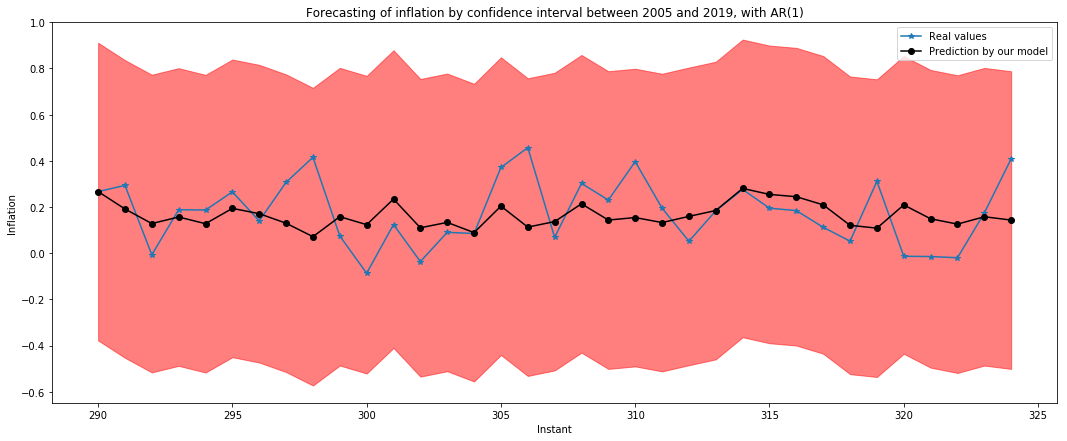

In [55]:
phi = ar_1(Y_train)
print(phi)
n = Y_test.shape[0]
v = var(Y_train, phi)
Y_est = ar_1_rappel(Y_test.values[0], phi, v, n, 50)
plt.figure(figsize=(18,7))
plt.plot(date_test,Y_test, marker='*', label="Real values")
plt.title('Forecasting of inflation by confidence interval between 2005 and 2019, with AR(1)')
plt.xlabel('Instant')
plt.ylabel('Inflation')
plot_mean_and_CI(Y_est[1], Y_est[0], Y_est[2], color_mean='k', color_shading='r')
plt.legend()

_Phase de validation_

In [56]:
def valid_(Xtest, Xsup, Xinf):
    N = Xtest.shape[0]
    k = 0
    for t in range(N):
        if (Xinf[t] <= Xtest[t] and Xtest[t] <= Xsup[t]):            
            k = k+1
    return round(100 * k / N, 2)

valid_ar_1 = valid_(Y_test.values, Y_est[0], Y_est[2])
print(valid_ar_1, "%")

valid__.append(valid_ar_1)
eqm__.append(eqm(Y_est[1], Y_test.values))

100.0 %


<hr>

## <div id="arp"><font color=darkred>  Autorégressif d'ordre p > 1 </font></div>

### AR(p) model (Modèle autoregressif d'ordre p)
$$X_{t} = a + \phi_{1} * X_{t-1} + ... + \phi_{p} * X_{t-p} + \epsilon_{t}$$
### En utilisant les fonctions d'autocorrélation $\rho_{t}$
$$ \rho_{k} = \sum_{i=1}^{p} \phi_{i}*\rho_{k-i}, \forall k > p$$
### Il faut donc résoudre le système linéaire pour trouver les paramètres du modèles. Mais comme on ne connait pas les $\rho_{k}$, il faut les estimer. On a :
$$\hat{\rho_{k}} = \frac{\sum_{t=1}^{T-k} (X_{t}-\hat{X})*(X_{t+k}-\hat{X})}{\sum_{t=1}^{T} (X_{t}-\hat{X})^2}, \forall k >= 0$$
### On trouve les $\phi_{k}$ en résolvant le système linéaire suivant (obtenu par les équations de Yule-Walker):
$$
\begin{pmatrix}
   \rho_1 \\
   \rho_2 \\
   ...\\
   \rho_p
\end{pmatrix} = 
\begin{pmatrix}
   1 & \rho_1 & \rho_2 & ... & \rho_{p-1} \\
   \rho_1 & 1 & .... & ... & . \\
   ... & ... & ... & ... & \rho_{1} \\
   \rho_{p-1} & ... & ... & \rho_{1} & 1 
\end{pmatrix}
\begin{pmatrix}
   \phi_1 \\
   \phi_2 \\
   ...\\
   \phi_p
\end{pmatrix}
$$
### On a en plus:
$$\hat{a} = \hat{\pi} * (1 - \sum_{k=1}^{p} \hat{\phi_{k}})  ====>  \hat{\pi} = \frac{1}{T} \sum_{t=1}^{T} \pi_{t} $$ 

_Calcul des $\hat{\phi}$ et de $\hat{a}$_

In [57]:
def compute_phi(X, p):
    gamma = np.correlate(X,X,'full')
    n=gamma.shape[0]
    autocor = gamma[n//2:n//2+p+1]/gamma[n//2]
    #print(autocor)
    A   = linalg.toeplitz(autocor[:p])
    #print(A)
    phi = linalg.inv(A).dot(autocor[1:p+1])
    c = np.mean(X)  * (1 - np.sum(phi))
    return [c, phi]

#### Estimation de la variance de l'erreur $\epsilon_{t}$ de moyenne $\sigma^{2}$
_En utilisant la fonction de vraissemblance_

$\hat{\sigma^{2}} = \frac{1}{T} * \sum_{t=1}^{T} \epsilon_{t}^2 $ avec $\epsilon_{t} = X_{t} - \phi_{1} * X_{t-1} + ... + \phi_{p} * X_{t-p}$  où T est la taille de l'ensemble d'entrainement. 

In [58]:
def var_p(X, phi, p):
    n = X.shape[0]
    v = 0
    for t in range(p, n):
        X_est = X[t] - phi[0]
        for i in range(p): 
            X_est -= phi[1][i] * X[t-i-1] 
        v += X_est * X_est
    return v / n

_Fonction qui estime les futures données_

In [59]:
def ar_p_rappel(xp, phi, v, p, n, N):
    X_est = np.zeros(n)
    X_sup = np.zeros(n)
    X_inf = np.zeros(n)
    
    for k in range(N):
        X = np.zeros(n)
        for t in range(p):
            X[t] = xp[t]

        for t in range(p, n):
            X[t] = phi[0] + np.sqrt(v) * np.random.randn()
            for i in range(p): 
                X[t] += phi[1][i] * X[t-i-1]
                
        for t in range(n):
            X_est[t] += X[t]
            
    for t in range(n):
        X_est[t] /= N
        X_sup[t] = X_est[t] + 1.96 * np.sqrt(v) #Borne supérieure de l'intervalle de confiance
        X_inf[t] = X_est[t] - 1.96 * np.sqrt(v) #Borne inférieure de l'intervalle de confiance
        
    return X_inf, X_est, X_sup


_Phase de test_

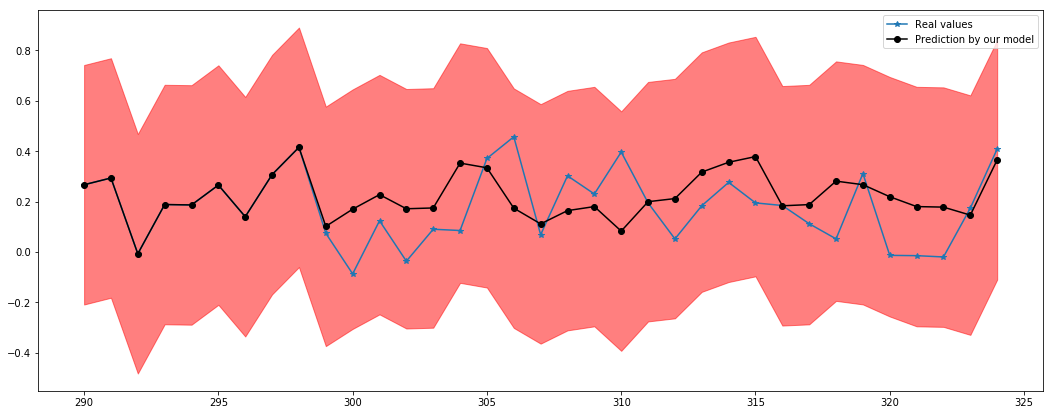

In [60]:
# Nombre de paramètres du modèle
p = 9
xp = Y_test.values[0:p]
# Estiméation par notre modèle
phi = compute_phi(Y_train, p)
v = var_p(Y_train, phi, p)
Y_est = ar_p_rappel(xp, phi, v, p, Y_test.values.shape[0], 10)
plt.figure(figsize=(18,7))
plt.plot(Y_test, marker='*',label="Real values")
plot_mean_and_CI(Y_est[1], Y_est[0], Y_est[2], color_mean='k', color_shading='r')
plt.legend()

### On veut choisir l'ordre p qui optimise notre modèle AR(p)
_On utilise le critère BIC qui dit que :_

$BIC(p) =  -2 * ln (L(p)) + k * ln(N)$ où k est le nombre de paramètres libres du modèle et N est le nombre d'observations

In [61]:
def bic(X, p):
    T = X.shape[0] 
    phi = compute_phi(X, p)
    v = var_p(X, phi, p)
    
    # Calcul de la log-vraissemblance
    l = 0    
    for t in range(p, T):
        X_est = X[t] - phi[0]
        for i in range(p): 
            X_est -= phi[1][i] * X[t-i-1] 
        l += X_est * X_est
    l = -l / (2*v)
    l -=  (T-p) * (np.log(2*np.pi) + np.log(v))/ 2
    return -2 * l + (p+2) * np.log(T)

_Ainsi, le p qui optimise est tel que p : $p_{opt} = arg min_{p}(BIC(p))$_

In [62]:
def find_p_opt(X, N):
    bic_ = np.zeros(N-1)
    p_opt = 1
    b_opt = bic(X, p_opt) 
    bic_[0] = b_opt
    for p in range(2,N):
        b = bic(X, p)
        bic_[p-1] = b
        if b < b_opt:
            b_opt = b
            p_opt = p
    plt.figure(figsize=(18,7))
    plt.plot(bic_)
    plt.title('Choix de p optimal par la méthode BIC.')
    return p_opt


_Phase de test pour le modèle AR(p opt)_

1


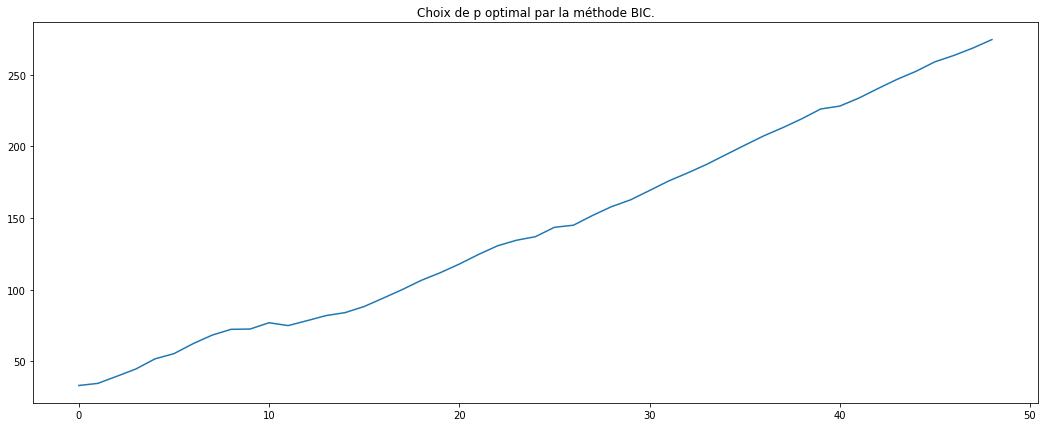

In [63]:
p = find_p_opt(Y_train, 50)
print(p)

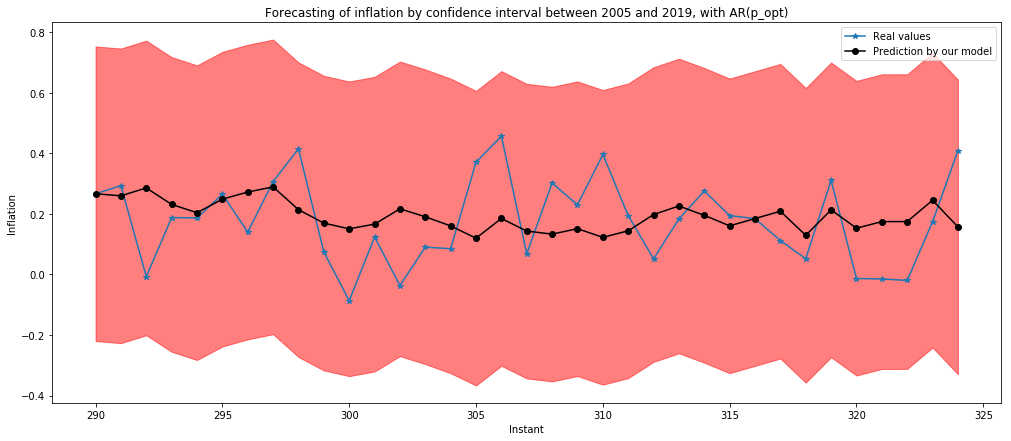

In [64]:
xp = Y_test.values[0:p]
# Estiméation par notre modèle
phi = compute_phi(Y_train, p)
v = var_p(Y_train, phi, p)
Y_est = ar_p_rappel(xp, phi, v, p, Y_test.values.shape[0], 50)
Y_ar_p = Y_est
plt.figure(figsize=(17,7))
plt.plot(Y_test, marker='*', label="Real values")
plt.title('Forecasting of inflation by confidence interval between 2005 and 2019, with AR(p_opt)')
plt.xlabel('Instant')
plt.ylabel('Inflation')
plot_mean_and_CI(Y_est[1], Y_est[0], Y_est[2], color_mean='k', color_shading='r')
plt.legend()

In [65]:
valid_ar_p = valid_(Y_test.values, Y_est[2], Y_est[0])
print(valid_ar_p, "%")
valid__.append(valid_ar_p)
eqm__.append(eqm(Y_est[1], Y_test.values))

100.0 %


<hr>

## <div id="lasso"><font color=darkred>  Lasso </font></div>

  #### Dans ce modèle , dispose d'observations n numériques $(X_i)_{i \in [1, n]}$  qui représentent chacune une ligne de la matrice X  et  des observations correspondantes $(Y_i)_{i \in [1, n]}$

   _Chaque vecteur $X_i$ étant de taille p, la matrice $X$ est de taille $nxp$_

  #### Ce modèle linéaire permet d'expliquer les  $(Y_i)_{i \in [1, n]}$  de telle sorte qu'on ait :
  
  ###### Pour tout i $\in [1, n]$ , $Y_i= \beta_i *X_i + \epsilon_i $ 
  
  #### Ou encore ,   $Y = X\beta + \varepsilon$   avec  $\beta = (\beta_i)_{i \in [1, p]}$ inconnu et $\varepsilon = (\epsilon_i)_{i \in [1, n]}$  independantes centrées et telle que  $Var[\epsilon_i]= \sigma^2$ inconnu.
  
  #### Le but de la régréssion est d'estimer le $\beta$ qui explique le mieux les données 

In [66]:
acp = decomposition.PCA(svd_solver='full')
coord = acp.fit_transform(X_train)
ratio=acp.explained_variance_ratio_

#### La solution au problème de la régression  Lasso est  la suivante  : 

####  $\hat{\beta_L} = Argmin_{\beta \in R^p}$ { $|| Y-X\beta||^2_2  + \lambda ||\beta||_1 $ } 

Ainsi , la régréssion de Lasso est une régression pénaliséé, et le facteur de pénalisation  $ \lambda ||\beta||_1 = \lambda \sum_{i=1}^{p}|\beta_i| $  permet de sélectionner les variables importantes de la regression et mettre à zéro les variables moins importantes. Ceci a un avantage important dans l'interprétation des résultats finaux obtenus. 


#### Après résolution du problème convexe ci dessus par la méthode de gradient, on obtient la solution approchée suivante : 

Pour tout i $\in [1, p] , \beta^*_i = V_{i} (1 - \frac{1}{2 |V_j|})_+ $ avec $V_i = \overset{}{X^*_i}(Y- \underset{j\neq i}{\sum_{j=1}^{p}} \beta_j \overset{~}{X_j})$

On a donc $\beta_i=0$ lorsque $1 - \frac{1}{2 |V_j|}=0 $



##### L'algorithme se déroule donc composante par composante de facon itérative , et il consiste à choisir un B initial aléatoire et de faire des mises à jours successives , jusqu'à ce qu'il y ait convergence. 

##### La question de convergence reste essentielle dans ce cas, on choisi un epsilon qui caracterisera la convergence , pour l'instant , on ajoutera pas un critère sur le nombre d'itérations vu que la convergence se réalise plutôt bien avec ce seul critère . 

In [67]:
def lasso(Y,X,n,lambda_pen):
    beta = np.zeros(n).transpose()
    beta_new= 10*np.random.randn(n).transpose()
    #for k in range(1):
    while np.linalg.norm(beta_new-beta)>1 : 
        beta=beta_new
        L=[i for i in range(n)]
        for i in L :
            X_i= X[:,i] #X.iloc[:,i].values  X[:,i]
            S= np.zeros(X.shape[0])
            for j in L:
                if j !=i:
                    S+= beta[j]*(X[:,j])  #beta[j]*(X.iloc[:,j].values)      
            v_i= np.vdot(X_i.transpose(),Y-S)   #Y.values
            value=1-lambda_pen/(2*abs(v_i))  #v_i[0]
    
            if value<0: 
                beta_new[i]=0
            else: 
                beta_new[i]= value*v_i   #v_i[0]
      
    return beta_new 

_On teste ici notre algorithme sur les donnés d'entraînement pour obtenir un vecteur beta_

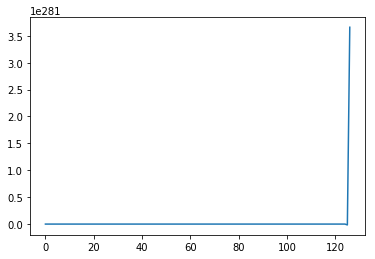

In [68]:
beta=lasso(Y_train.values,X_train,127,10000)
#print(beta)
plt.plot(beta)

_On remarque que le vecteur beta obtenu,même avec un facteur lambda de pénalisation assez grand,explose rapidement, ce qui n'est pas très cohérent. On va donc tester notre algorithme avec des données simulées pour voir s'il y a cohérence de résutats._

In [69]:
Xs=100*np.random.randn(10,5)
Xs[:,1]=0.5*np.ones(10)
beta=2*np.ones(5)
#beta[]
def sample_r(n,beta, Xs):
    Y = np.zeros(n)
    for i in range(n):
        Y[i]= np.dot(Xs[i],beta) + np.random.randn()
    return Y
Ys=sample_r(10,beta,Xs)
#print(type(X))
soluce=lasso(Ys,Xs,5,10)
print(Ys)
print(soluce)
print(np.dot(Xs,soluce))

[ 925.51052642 -125.19026274 -445.81289987  306.34967829  387.03081089
 -324.24013734  182.599934    107.3496683  -202.63611024 -865.00485291]
[ 3.50681700e+05 -1.12519768e+07 -3.36995588e+09  2.15000853e+14
 -9.65287798e+17]
[-4.50118425e+19  7.71160714e+19  7.24204297e+19 -3.82232959e+19
 -7.00523621e+19 -7.40408274e+19 -1.07466880e+20 -1.45210987e+19
  7.80977610e+19  1.21233824e+19]


_On constate malheureusement qu'il y a toujours une explosion assez rapide du vecteur recherché. C'est un algorithme basé sur le gradient, qui est alors tres sensible aux donnés d'initialisation . On n'obtient donc finalement pas de bons résultats avec cet algorithme de Lasso malgré les vecrifications diverses._

_Calcul de l'erreur quadratique moyenne_

In [70]:
def eqm(Y,X,beta):
    e = 0
    n = Y.shape[0]
    for i in range(n):
        e = (Y[i] - np.dot(X[i,:],beta))**2
    return np.sqrt(e/n)
print(eqm(Ys,Xs,soluce))

3.8337501235001825e+18


### LASSO de Pandas

In [71]:
from sklearn import linear_model
lasso = linear_model.Lasso(fit_intercept=True)

lasso.set_params(alpha=0.000001)
lasso.fit(X_train, Y_train)
a = lasso.predict(X_train)

_Variance de l'estimateur_

In [72]:
def var_(Y_train, Y):
    sigma = 0
    T = Y.shape[0]
    
    for i in range(T):
        sigma += (Y[i] - Y_train[i])**2
    return (sigma / T)
v = var_(Y_train.values, a)

_Construction de l'intervalle de confiance_

In [73]:
def build_interval_confident(X, v):
    X_sup = X + 1.96 * np.sqrt(v) #Borne supérieure de l'intervalle de confiance
    X_inf = X - 1.96 * np.sqrt(v) #Borne inférieure de l'intervalle de confiance
    #print(X_sup)
    return X_inf, X, X_sup

_Phase de test_

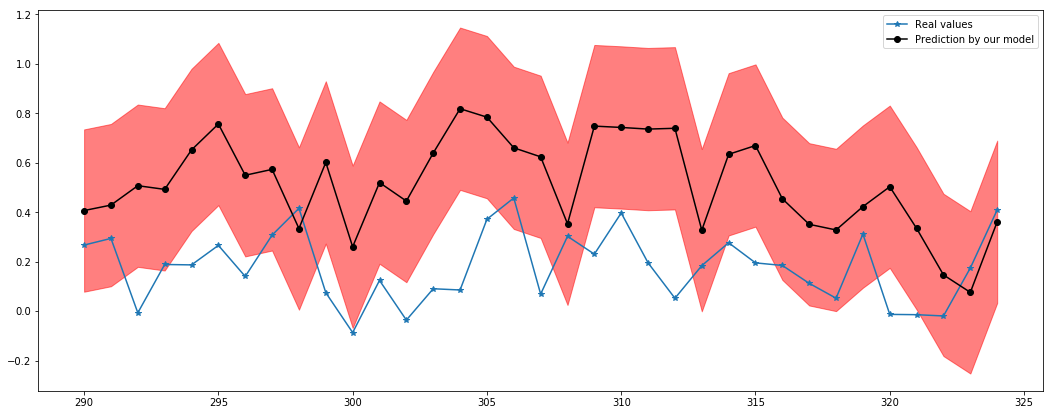

In [74]:
n = 50
b = np.zeros(Y_test.shape)
for i in range(n):
    b = b + lasso.predict(X_test)
b = b / n
Y_est = build_interval_confident(b, v)
plt.figure(figsize=(18,7))
plt.plot(Y_test, marker='*', label="Real values")
plot_mean_and_CI(Y_est[1], Y_est[0], Y_est[2], color_mean='k', color_shading='r')
plt.legend()

_Validation du modèle_

In [75]:
def eqm(yw, ye):
    e = 0
    #print(ye.shape, yw.shape)
    n = ye.shape[0]
    for i in range(n):
        e += (yw[i] - ye[i])**2
    return np.sqrt(e/n)

valid_lasso = valid_(Y_test.values, Y_est[2], Y_est[0])
print(valid_lasso, "%")
valid__.append(valid_lasso)
eqm__.append(eqm(Y_est[1], Y_test.values))

42.86 %


<hr>

## <div id="factor"><font color=darkred>  Modèles factoriels </font></div>

## Description du modèle

#### On note $X$ de taille TxN qui décrit les données observées (N le nombre de variables observées et T le nombre de mois)
#### On note $p$ le nombre de facteurs (provisoires)
### Le modèle factoriel consiste à utiliser $\Lambda_{t}$ et $F_{t}$ pour estimer une grandeur $\pi_{t+h}$ 
#### $\Lambda_{t}$ et $F_{t}$ vérifient la relation $\forall t \in [1,T]$ $\forall i \in [1,N]$ $X_{it} = \lambda_i (L) * F_t + e_{it} $ 
####  $λ_i (L)$ est tel que $\frac{\Lambda' \Lambda}{N} = I_{p}$ où $\Lambda = (\lambda_i)_{i \in [1, p]}$
#### $F_t = (f_{u})_{u \in [t, t-p]}$ sont les facteurs à calculer

## Estimation des paramètres

####  $\hat{\lambda_i(L)}$ le vecteur propre associé à la ième valeur propre la plus grande de la matrice de covariance de X'X multiplié par $\sqrt N$
#### $\hat{F} = \frac{X \hat{\Lambda}}{N}$

## Estimation de l'inflation
$\pi_{t+h}$ = $ \sum_{i=1}^{p} \hat{\Lambda_{i}}' * \hat{f_{t-i}} + e_{t+h} $

_Prends en entrée les données observées et retourne les p vecteurs propres associées aux p valeurs propres les plus grandes_

In [76]:
def lambda_(X, p):
    N = X.shape[1]
    A = np.transpose(X).dot(X)
    values, vectors  = np.linalg.eig(A)
    #print(float(100 * np.sum(values[0:p]) / np.sum(values)))
    e_vectors = np.zeros((p, N))
    for i in range(p):
        e_vectors[i] = np.transpose(vectors[:,i]) 
    return (np.sqrt(N) * e_vectors)

_Prends en paramètres la matrice $\Lambda$ et les données $X$ et retourne F_

In [77]:
def F_(X, lambd):
    N = X.shape[0]
    return X.dot(lambd.transpose()) / N

### Phase d'estimation du paramètre linéaire

##### A partir de l'ACP qu'on a faite, on a le modèle d'estimation linéaire suivante $\pi_{t} = a + F_{t} * \beta + \epsilon_{t}$ avec $\pi_{t}$ de dimension 1, $F_{t}$ de dimension 1 * q, $\beta$ de dimension q * 1

##### On obtient donc $\hat{\beta} = (F_{t}'F_{t})^{-1} * F_{t}' * \pi_{t}$ ou pour les cas généralisé $\hat{\beta} = (F_{t}' \Sigma^{-1} F_{t})^{-1} * F_{t}' *\Sigma^{-1}* \pi_{t}$ et $\hat{a} = \frac{1}{T} \sum_{t=1}^{T} \pi_{t} $

In [78]:
def beta(F, pi):
    q, N = F.shape
    #A = F.dot(F.transpose())
    #A = np.linalg.inv(A)
    bet = F.transpose().dot(F)
    #bet = bet.dot(F)
    bet = np.linalg.inv(bet)
    bet = bet.dot(F.transpose())
    #bet = bet.dot(A)
    bet = bet.dot(pi)
    return bet

_Estimation de la variance de l'erreur gaussienne_

In [79]:
def var_(F, Y, beta):
    sigma = 0
    T = Y.shape[0]
    for i in range(T):
        sigma += (Y[i] - beta.transpose().dot(F[i, :]))**2
    return (sigma / T)

_Phase de rappel_

In [80]:
def rappel_(l, X, beta, m, v, p):
    F = F_(X, l)
    e = np.sqrt(v) * np.random.randn(F.shape[0], 1)
    r = F.dot(beta) + m
    r = r + e
    return r

_Choix du nombre de variables qui maximise l'erreur quadratique moyenne_

In [81]:
def optimise_p(X_train, Y_train, N, yt):
    eq = np.zeros(N)
    p_opt = 1
    eqm_opt = 1000
    for p in range(1,N):
        lambd = lambda_(X_train, p)
        F = F_(X_train, lambd)
        b = beta(F, Y_train.values)
        v = var_(F, Y_train.values, b)
        m = np.mean(Y_train.values)
        Y = rappel_(lambd, X_test, b, m, v, p)[:,0]
        eq[p] = eqm(Y, yt)
        if eq[p] < eqm_opt:
            eqm_opt = eq[p]
            p_opt = p
    plt.figure(figsize=(17,7))
    plt.plot(eq)
    return p_opt

_Phase de test_

49


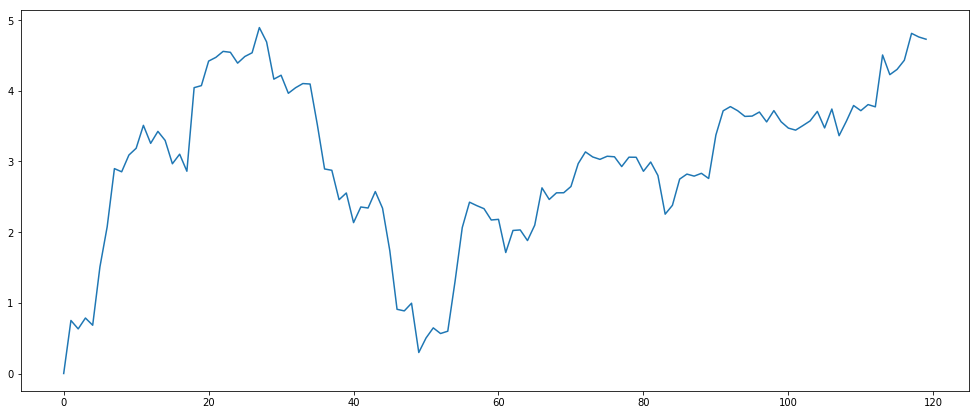

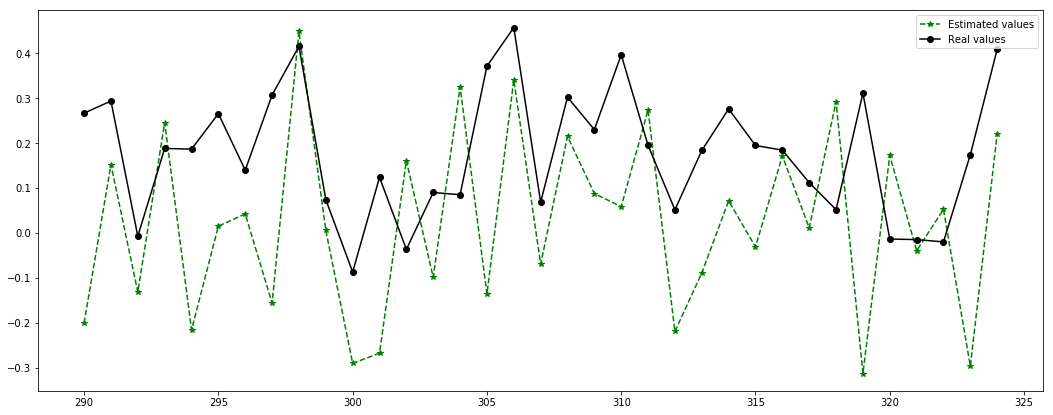

In [82]:
N = 120
p = optimise_p(X_train, Y_train, N, Y_test.values)
print(p)
lambd = lambda_(X_train, p)
F = F_(X_train, lambd)
b = beta(F, Y_train.values)
v = var_(F, Y_train.values, b)
m = np.mean(Y_train.values)
r = rappel_(lambd, X_test, b, m, v, p)
vt = var_(F, r, b)
#print(v, vt)
plt.figure(figsize=(18,7))
plt.plot(date_test, r[:,0], 'g--', marker='*', label="Estimated values")
plt.plot(date_test, Y_test, label="Real values", marker='o',color='k')
plt.legend()

### Estimation par intervalle de confiance

In [83]:
def fm_rappel(l, X, beta, m, v, p, N):
    n= X.shape[0]
    X_est = np.zeros(n)
    X_sup = np.zeros(n)
    X_inf = np.zeros(n)
    
    for k in range(N):
        X_est += rappel_(l, X, beta, m, v, p)[:,0]
        
    X_est /= N
    X_sup = X_est + 1.96 * np.sqrt(v) #Borne supérieure de l'intervalle de confiance
    X_inf = X_est - 1.96 * np.sqrt(v) #Borne inférieure de l'intervalle de confiance
        
    return X_inf, X_est, X_sup

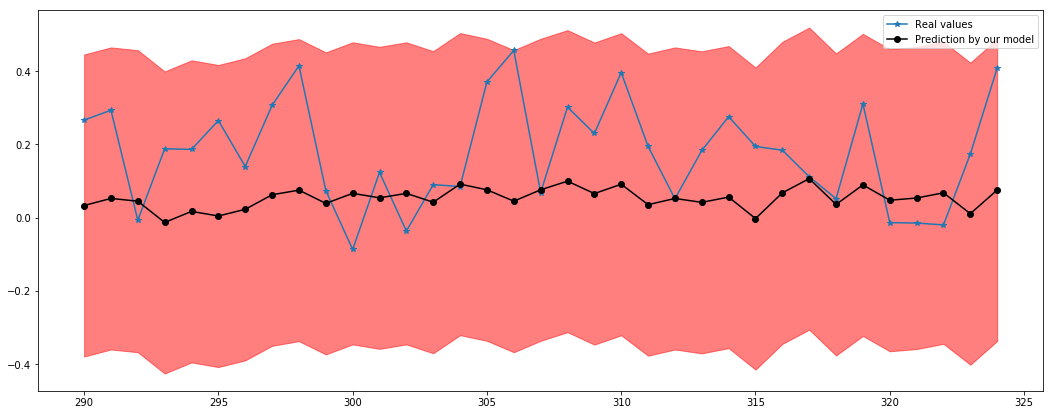

In [84]:
N = 50
Y_bar = np.mean(Y_train)
lambd = lambda_(X_train, p)
F = F_(X_train, lambd)
b = beta(F, Y_train)
m = np.mean(Y_train)
v = var_(F, Y_train, b)
Y_est = fm_rappel(lambd, X_test, b, m, v, p, N)
plt.figure(figsize=(18,7))
plt.plot(Y_test, marker='*',label="Real values")
plot_mean_and_CI(Y_est[1], Y_est[0], Y_est[2], color_mean='k', color_shading='r')
plt.legend()

_Validation du modèle_

In [85]:
valid_factor = valid_(Y_test.values, Y_est[2], Y_est[0])
print(valid_factor, "%")
valid__.append(valid_lasso)
eqm__.append(eqm(Y_est[1], Y_test.values))

100.0 %


<hr>

## <div id="forest"><font color=darkred>  Forêts aléatoires </font></div>

_collecter les indices des caractéristiques les plus importantes._

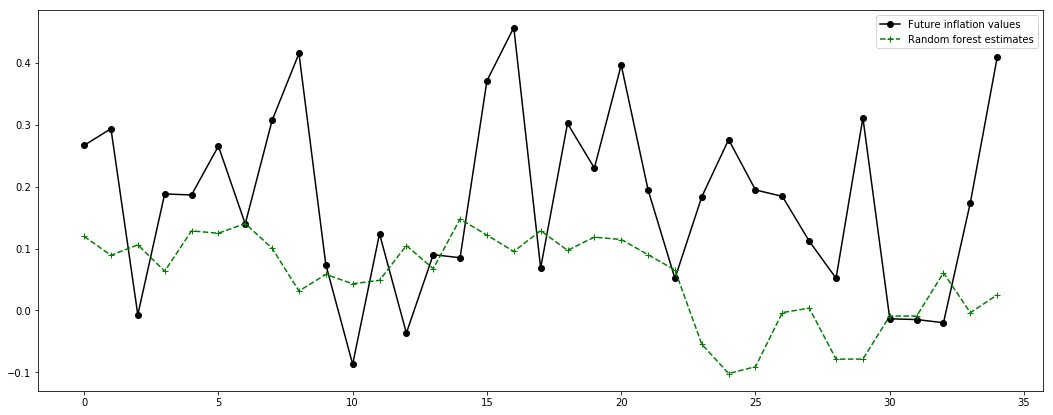

In [86]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)

plt.figure(1,figsize=(18,7))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

_Optimisation de l'algorithme, notamment en choisissant le nombre de variables à conserver_

In [87]:
d_max = 120
MSE   = []
rf    = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)
for d in range(2,d_max): 
    rfd = RandomForestRegressor(n_estimators = n_trees)
    ind = rf.feature_importances_.argsort()[-d:]
    rfd.fit(X_train[:,ind],Y_train)
    # compute predictions usting test data and associated mean square error
    y_pred_rf = rfd.predict(X_test[:,ind])
    MSE = np.append(MSE,mean_squared_error(Y_test,y_pred_rf))

Text(0, 0.5, 'Mean square error on the test data set')

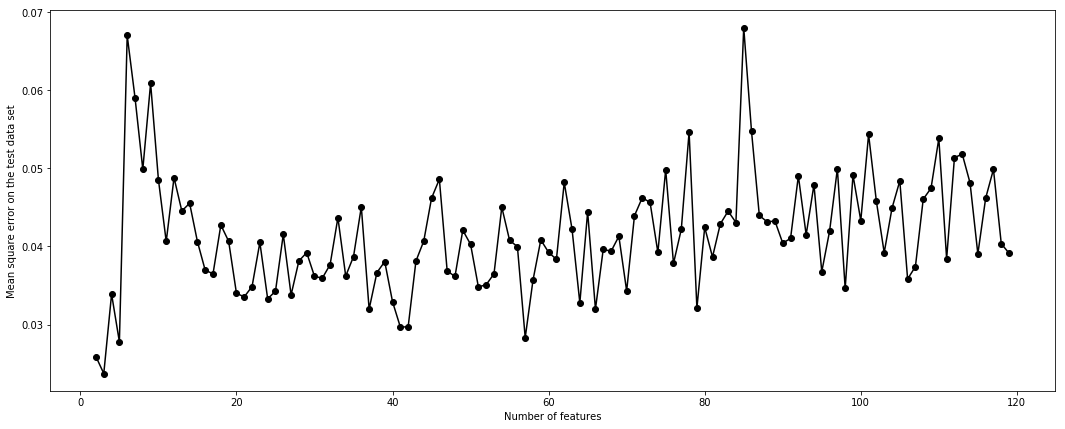

In [88]:
plt.figure(1,figsize=(18,7))

plt.plot(range(2,120), MSE,marker='o',color='k')
plt.xlabel('Number of features')
plt.ylabel('Mean square error on the test data set')

_Variance de l'estimateur_

In [89]:
def var_(Y_train, Y):
    sigma = 0
    T = Y.shape[0]
    
    for i in range(T):
        sigma += (Y[i] - Y_train[i])**2
    return (sigma / T)
v = var_(Y_train.values, a)
print(v)

0.027993815756780477


_construction de l'intervall de confiance_

In [90]:
nb_features_to_keep = MSE.argmin() + 2
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train_rf =  X_train[:,ind]

n_trees = 50
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train_rf,Y_train)
a = rf.predict(X_train_rf)
# compute predictions usting test data and associated mean square error
Y_est = rf.predict(X_test[:,ind])

In [91]:
Y = build_interval_confident(Y_est, v)

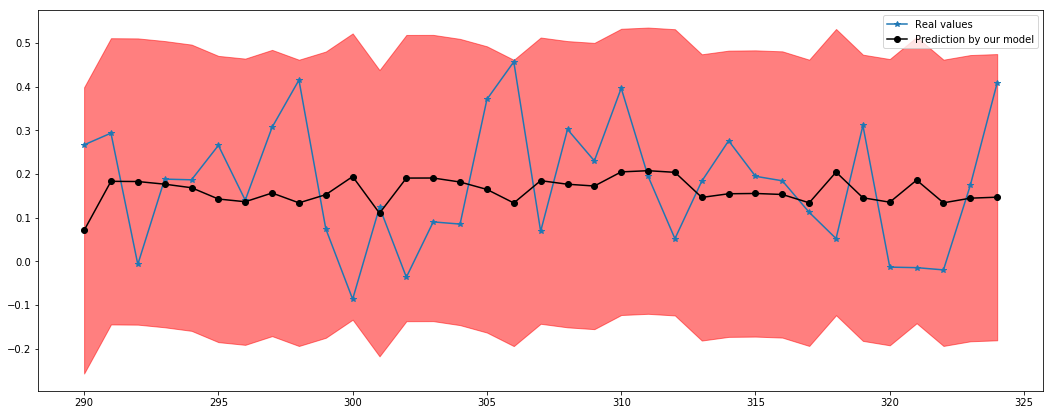

In [92]:
plt.figure(figsize=(18,7))
plt.plot(Y_test, marker='*', label="Real values")
plot_mean_and_CI(Y[1], Y[0], Y[2], color_mean='k', color_shading='r')
plt.legend()

In [93]:
valid_forest = valid_(Y_test.values, Y[2], Y[0])
print(valid_forest, "%")
valid__.append(valid_forest)
eqm__.append(eqm(Y[1], Y_test.values))

100.0 %


<hr>

## <div id="compare"><font color=darkred>  Comparaison des modèles </font></div>

In [94]:
model__ = np.array(["AR(1)", "AR(P)", "LASSO", "FACTOR", "FOREST"])
print(eqm__)
print(valid__)
print(model__)

[0.14608707673820098, 0.14888632754743486, 0.39307883521116943, 0.18906151837573554, 0.15357889309416553]
[100.0, 100.0, 42.86, 42.86, 100.0]
['AR(1)' 'AR(P)' 'LASSO' 'FACTOR' 'FOREST']


_Courbe des erreurs quadratiques moyennes_

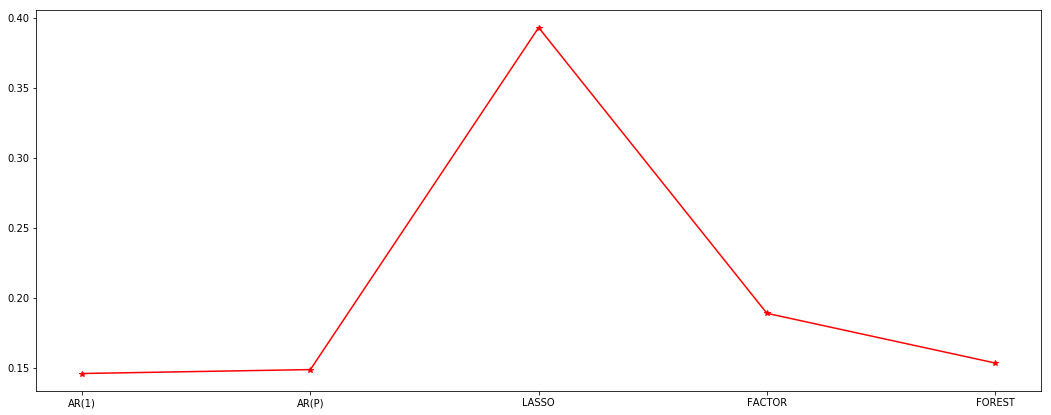

In [95]:
plt.figure(figsize=(18,7))
plt.plot(model__, eqm__, marker='*', color='r')

_Courbe de l'appartenance à l'intervalle de confiance_

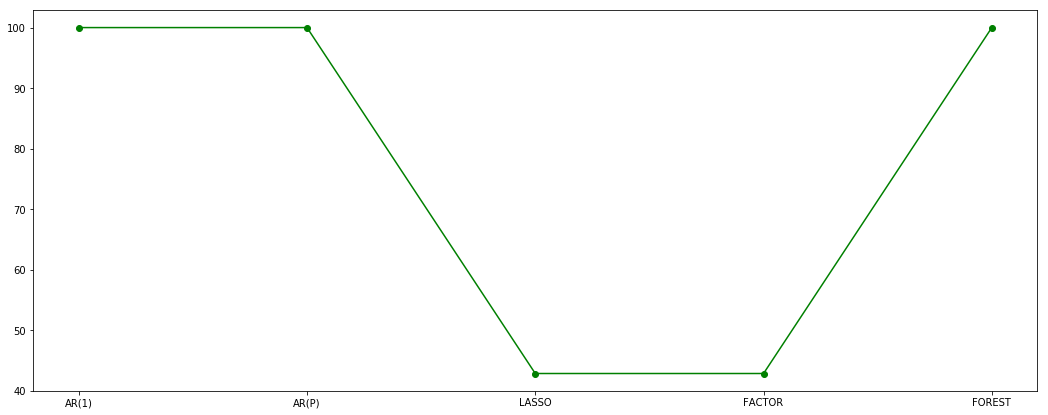

In [96]:
plt.figure(figsize=(18,7))
plt.plot(model__, valid__, marker='o', color='g')

In [97]:
d = pd.DataFrame()
d.insert(0, "MODELE", model__)
d.insert(1, 'ERREUR QUADRATIQUE MOYENNE', eqm__)
d.insert(2, '% DE VALIDATION', valid__)
d.head()

,MODELE,ERREUR QUADRATIQUE MOYENNE,% DE VALIDATION
0,AR(1),0.146087,100.00
1,AR(P),0.148886,100.00
2,LASSO,0.393079,42.86
3,FACTOR,0.189062,42.86
4,FOREST,0.153579,100.00


<hr>

## <div id="conclusion"><font color=darkred>  Conclusion</font></div>

<p>
     L'objectif de ce projet long de 6 mois était d'utiliser les modèles de Machine Learning pour prédire l'inflation des USA. Les données allant de 1960 à 2019, soit environ 720 instants ont été traitées et on été ramenées à 325 instants. <b>Soit 295 pour l'ensemble d'apprentissage et 30 pour l'ensemble de test.</b><br><br>
    Pour chaque modèle, l'ensemble d'apprentissage permet d'estimer les paramètres du modèle, et l'ensemble de test permet de voir comment le modèle se comporte comparé aux valeurs réelles.<br><br>
    La validation de chaque modèle est faite par INTERVALLE DE CONFIANCE. à 95%.<br><br>
    La grande différence est que : les modèles autoregressifs utilisent que des valeurs précédentes de l'inflation pour estimer les paramètres du modèles. Par contre, les autres modèles (LASSO, Factoriels, Forêts aléatoires, ...), utilisent non seulement les valeurs précédentes de l'inflation, mais aussi les autres variables économiques.<br><br>
    Les modèles de Machine Learning actuels ont plus pour certains, l'objectif de déterminer les principales variables économiques qui influencent l'inflation. On observe que dans la plupart des cas, les taux d'intérêts inluencent l'inflation à près de 45% (ACP). Cela confirme ce qu'il se passe souvent dans la réalité:  <i>Les banques centrales pour contrôler l'inflation, augmentent ou baissent les taux d'intérêts.</i><br><br>
    Il a été difficile, à cause du temps, de développer les algorithmes pour le LASSO et les Forêts Aléatoires. Nous avons donc utiliser les algorithmes développer sur <b>sklearn</b> pour voir comment fonctionnent ces modèles.<br><br>
    Ce projet long nous a fortement initié à la recherche académique, car il a déjà fallu lire 2 articles de recherche qui au départ semblaient longs, mais qui finalement étaient courts. Il a donc fallu trouver d'autres sources et documents complémentaires. Il faut s'armer de patiente pour réaliser un tel projet.
</p>

<hr>

<center>Le 20 Juin 2019</center>